<a href="https://colab.research.google.com/github/abclark/constrained_birkhoff_von_neumann/blob/master/optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports


In [1]:

import numpy as np
from typing import Union, List
from matplotlib import pyplot as plt



## Constants


In [2]:

NUM_DECISIONS = 2
NUM_STATES = 2
PRIOR = np.array([0.5, 0.5])
CONTRACT = np.array([[1, 2], [2, 1]])
EXPERIMENT = np.array([[0.5, 0.5], [0.5, 0.5]])
UNINFORMATIVE_EXPERIMENT = np.array([[0.5, 0.5], [0.5, 0.5]])
MAX_INFORMATIVE_EXPERIMENT = np.array([[1, 0], [0, 1]])
ALWAYS_SIGNAL_ONE_EXPERIMENT = np.array([[1, 0], [1, 0]])



## Entropy


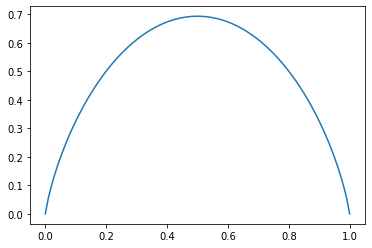

In [3]:

def get_entropy(p: List[float]):

  assert(len(p) == NUM_STATES)

  assert(sum(p) == 1)

  for i in p:
    assert(i >= 0)

  val = -sum([i * np.log(i) if i != 0 else 0 for i in p])

  return val

def test_get_entropy():
  
  assert(get_entropy([1, 0]) == 0)

  assert(get_entropy([0, 1]) == 0)

test_get_entropy()

# plot entropy
ts = np.linspace(0, 1, 100)
ps = [[t, 1 - t] for t in ts]
es = [get_entropy(i) for i in ps]
plt.plot(ts, es)



## Total Probabilities


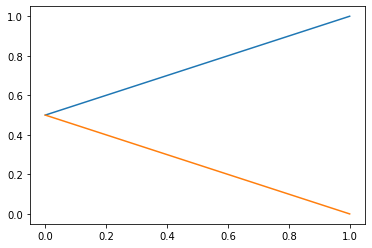

In [4]:

def get_signal_total_probability(experiment: List[List[float]]):

  val = [sum([experiment[i][j] * PRIOR[i] for i in range(NUM_STATES)]) for j in range(NUM_DECISIONS)] 

  return val


def test_get_signal_total_probability():

  assert(get_signal_total_probability(UNINFORMATIVE_EXPERIMENT)[0] == PRIOR[0])
  
  assert(get_signal_total_probability(ALWAYS_SIGNAL_ONE_EXPERIMENT)[0] == 1)


test_get_signal_total_probability()


ts = np.linspace(0, 1, 100)
ps = [(1 - t) * UNINFORMATIVE_EXPERIMENT + t * ALWAYS_SIGNAL_ONE_EXPERIMENT for t in ts]
tps = [get_signal_total_probability(i) for i in ps]
plt.plot(ts, tps)


## Posterior Probability

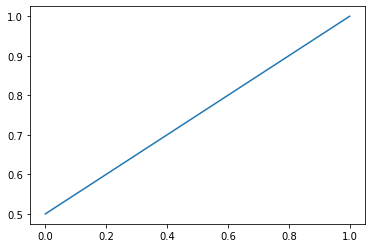

In [5]:

def get_posteriors(experiment: List[List[float]]):

  # p(state given signal) = p(signal and state) / p(signal)
  # p(signal and state) = p(signal given state) * p(state)
  # p(signal) = sum(p(signal and state) over states)


  tp = get_signal_total_probability(experiment) 

  posterior = np.array([[experiment[i][j] * PRIOR[i] / tp[j] if tp[j] != 0 else 0 for j in range(NUM_DECISIONS)] for i in range(NUM_STATES)])

  return posterior

def test_get_posteriors():

  assert((get_posteriors(MAX_INFORMATIVE_EXPERIMENT) == np.array([[1, 0], [0, 1]])).all())
  assert((get_posteriors(UNINFORMATIVE_EXPERIMENT) == np.array([PRIOR, PRIOR])).all())


test_get_posteriors()

# posterior probabilities for uninformative to maximally informative experiment
ts = np.linspace(0, 1, 100)
ps = [(1 - t) * UNINFORMATIVE_EXPERIMENT + t * MAX_INFORMATIVE_EXPERIMENT for t in ts]
tps = [get_posteriors(i) for i in ps]
plt.plot(ts, [tps[n][0][0] for n in range(len(tps))])

## Cost Function

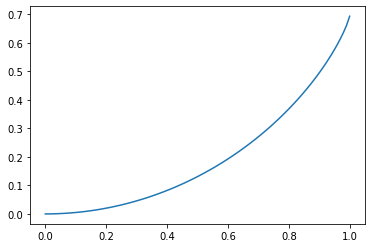

In [6]:
from IPython.core.events import post_run_cell


def get_experiment_cost(experiment: List[List[float]]):

  signal_total_probability = get_signal_total_probability(experiment)

  posteriors = get_posteriors(experiment)

  expected_posterior_entropy = sum(signal_total_probability[j] * get_entropy(posteriors[j]) for j in range(NUM_DECISIONS))

  val = get_entropy(PRIOR) - expected_posterior_entropy 

  return val

assert(get_experiment_cost(UNINFORMATIVE_EXPERIMENT) == 0)
assert(get_experiment_cost(MAX_INFORMATIVE_EXPERIMENT) == get_entropy(PRIOR))


# plot cost for uninformative to maximally informative experiment
ts = np.linspace(0, 1, 100)
ps = [(1 - t) * UNINFORMATIVE_EXPERIMENT + t * MAX_INFORMATIVE_EXPERIMENT for t in ts]
ecs = [get_experiment_cost(i) for i in ps]
plt.plot(ts, ecs)

## Benefit Function

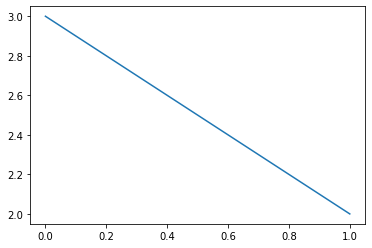

In [7]:

def get_experiment_benefit(contract: List[List[float]], experiment: List[List[float]]):
  
  benefit = sum([experiment[i][j] * contract[i][j] for i in range(len(contract)) for j in range(len(contract[0]))])

  return benefit


# plot benefit for uninformative to maximally informative experiment
ts = np.linspace(0, 1, 100)
ps = [(1 - t) * UNINFORMATIVE_EXPERIMENT + t * MAX_INFORMATIVE_EXPERIMENT for t in ts]
ebs = [get_experiment_benefit(CONTRACT, i) for i in ps]
plt.plot(ts, ebs)